In [1]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=5847684a4abf6637bf22914970dc80fc717ea6d5b67581b36d5bb1dd4ce6a866
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dataset_root = '/kaggle/input/animal-image-dataset-90-different-animals/animals/animals'
animal_classes = os.listdir(dataset_root)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class BinaryAnimalDataset(Dataset):
    def __init__(self, root_dir, target_class, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        
        self.data, self.targets = [], []
        
        for i, class_ in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_)
            images = os.listdir(class_dir)
            if class_ == target_class:
                self.data.extend([os.path.join(class_dir, image) for image in images])
                self.targets.extend([1] * len(images))
            else:
                num_samples = int(0.1 * len(images))
                images = random.sample(images, num_samples)
                self.data.extend([os.path.join(class_dir, image) for image in images])
                self.targets.extend([0] * len(images))
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        target = self.targets[index]
        
        return image, target

In [7]:
datasets = {}
for target_class in animal_classes:
    datasets[target_class] = BinaryAnimalDataset(dataset_root, target_class, transform)

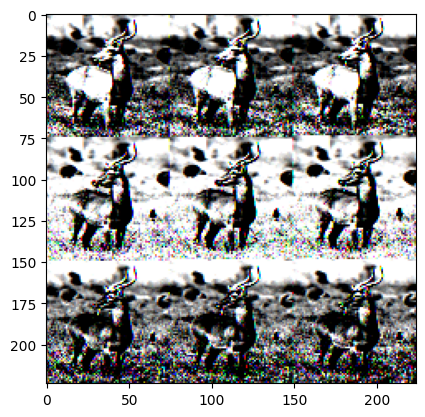

In [8]:
plt.imshow(datasets['antelope'][56][0].reshape(224, 224, 3))

In [9]:
class EfficientNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.fc = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.efficientnet(x)
        x = self.fc(x)
        return x

In [10]:
def train_model(model, epochs, train_loader, val_loader, criterion, optimizer, scheduler, fold):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (preds == labels.unsqueeze(1)).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_preds = []
        val_targets = []
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (preds == labels.unsqueeze(1)).sum().item()
                total_val += labels.size(0)

                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = correct_val / total_val

            val_losses.append(val_loss)
            val_accs.append(val_acc)

        scheduler.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.show()

In [11]:
num_epochs = 5
batch_size = 64

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Training for class: beetle
Fold 1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 193MB/s]


Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2933, Train Acc: 0.8763, Val Loss: 0.0604, Val Acc: 0.9798
Epoch [2/5], Train Loss: 0.0530, Train Acc: 0.9773, Val Loss: 0.1831, Val Acc: 0.9444
Epoch [3/5], Train Loss: 0.0308, Train Acc: 0.9848, Val Loss: 0.0826, Val Acc: 0.9747
Epoch [4/5], Train Loss: 0.0057, Train Acc: 1.0000, Val Loss: 0.0971, Val Acc: 0.9747
Epoch [5/5], Train Loss: 0.0675, Train Acc: 0.9975, Val Loss: 0.1031, Val Acc: 0.9747


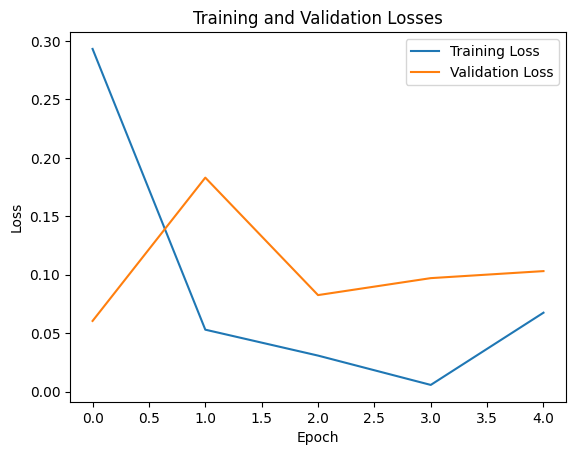

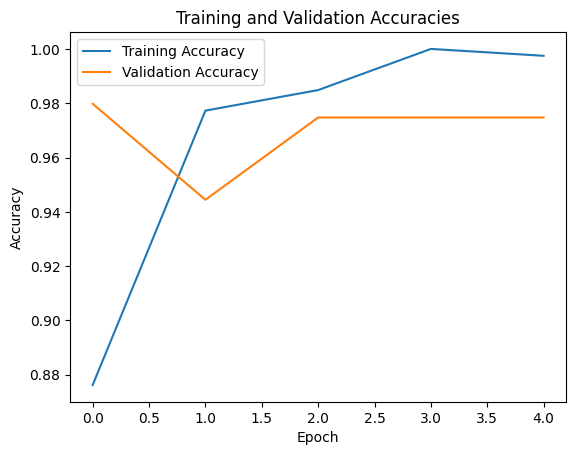

Fold 2
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2587, Train Acc: 0.8359, Val Loss: 0.0745, Val Acc: 0.9798
Epoch [2/5], Train Loss: 0.0151, Train Acc: 0.9949, Val Loss: 0.2047, Val Acc: 0.9747
Epoch [3/5], Train Loss: 0.0183, Train Acc: 0.9924, Val Loss: 0.2014, Val Acc: 0.9747
Epoch [4/5], Train Loss: 0.0116, Train Acc: 0.9975, Val Loss: 0.1881, Val Acc: 0.9697
Epoch [5/5], Train Loss: 0.0011, Train Acc: 1.0000, Val Loss: 0.1798, Val Acc: 0.9697


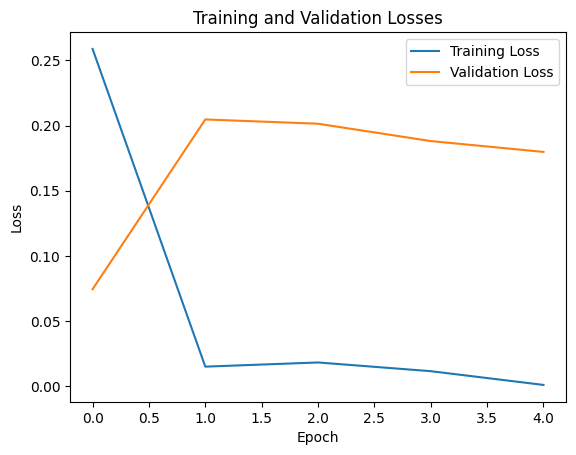

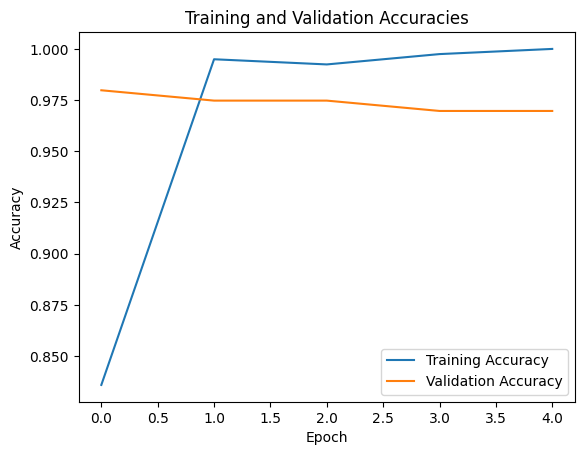

Fold 3
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2726, Train Acc: 0.8561, Val Loss: 0.1294, Val Acc: 0.9747
Epoch [2/5], Train Loss: 0.0296, Train Acc: 0.9924, Val Loss: 0.1282, Val Acc: 0.9697
Epoch [3/5], Train Loss: 0.0273, Train Acc: 0.9924, Val Loss: 0.3435, Val Acc: 0.9444
Epoch [4/5], Train Loss: 0.0740, Train Acc: 0.9975, Val Loss: 0.3610, Val Acc: 0.9444
Epoch [5/5], Train Loss: 0.0084, Train Acc: 0.9924, Val Loss: 0.3032, Val Acc: 0.9646


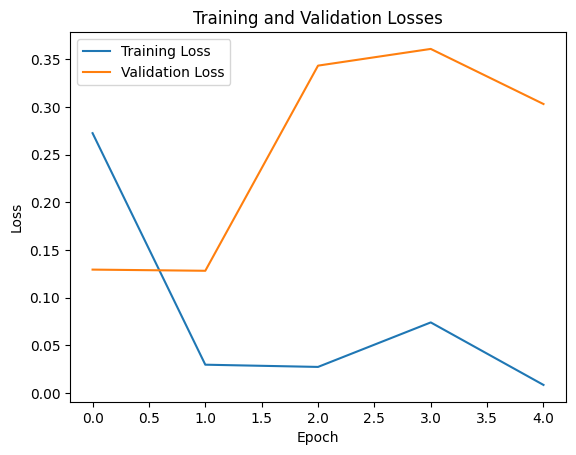

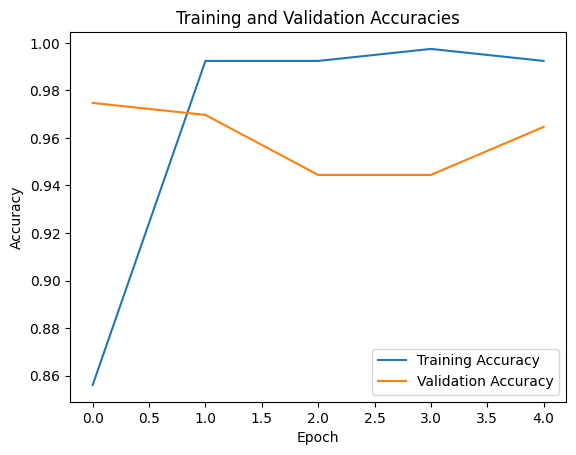

Training for class: parrot
Fold 1
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2784, Train Acc: 0.8510, Val Loss: 0.0330, Val Acc: 0.9899
Epoch [2/5], Train Loss: 0.0408, Train Acc: 0.9798, Val Loss: 0.0500, Val Acc: 0.9899
Epoch [3/5], Train Loss: 0.0273, Train Acc: 0.9874, Val Loss: 0.0896, Val Acc: 0.9899
Epoch [4/5], Train Loss: 0.0127, Train Acc: 0.9949, Val Loss: 0.0855, Val Acc: 0.9899
Epoch [5/5], Train Loss: 0.0053, Train Acc: 1.0000, Val Loss: 0.0856, Val Acc: 0.9899


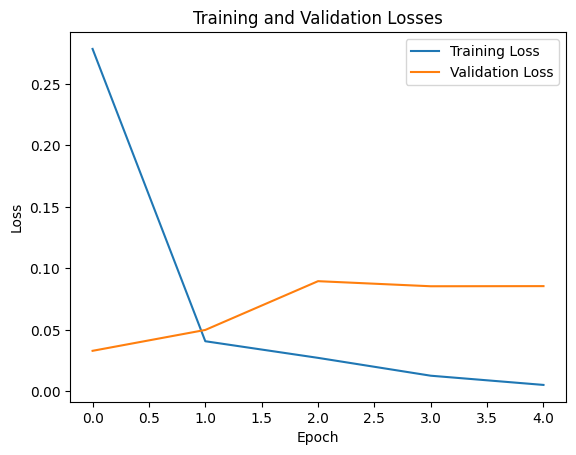

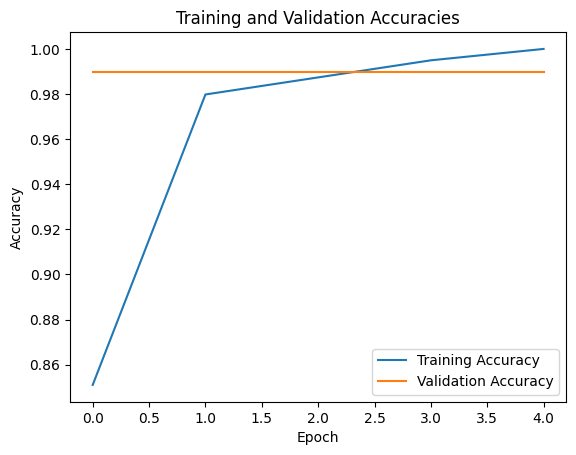

Fold 2
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2386, Train Acc: 0.8586, Val Loss: 0.0463, Val Acc: 0.9747
Epoch [2/5], Train Loss: 0.1082, Train Acc: 0.9949, Val Loss: 0.0625, Val Acc: 0.9747
Epoch [3/5], Train Loss: 0.0755, Train Acc: 0.9722, Val Loss: 0.4049, Val Acc: 0.9545
Epoch [4/5], Train Loss: 0.0327, Train Acc: 0.9924, Val Loss: 0.3690, Val Acc: 0.9596
Epoch [5/5], Train Loss: 0.0107, Train Acc: 0.9949, Val Loss: 0.3248, Val Acc: 0.9596


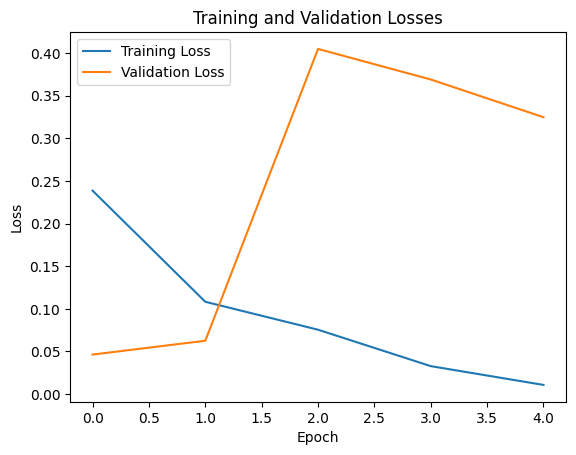

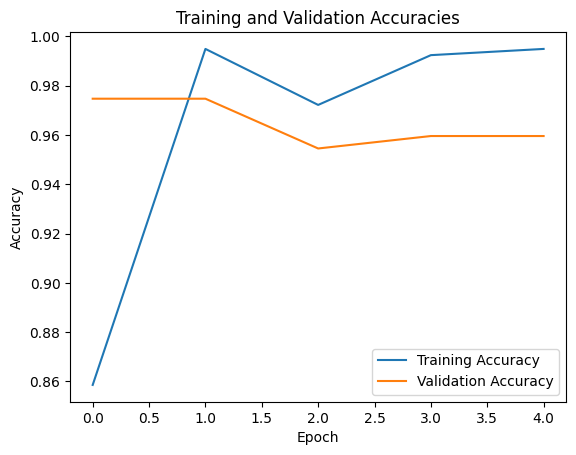

Fold 3
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2330, Train Acc: 0.8737, Val Loss: 0.0653, Val Acc: 0.9798
Epoch [2/5], Train Loss: 0.0359, Train Acc: 0.9848, Val Loss: 0.2299, Val Acc: 0.9596
Epoch [3/5], Train Loss: 0.0280, Train Acc: 0.9924, Val Loss: 0.0613, Val Acc: 0.9848
Epoch [4/5], Train Loss: 0.0028, Train Acc: 0.9975, Val Loss: 0.0600, Val Acc: 0.9848
Epoch [5/5], Train Loss: 0.0070, Train Acc: 1.0000, Val Loss: 0.0612, Val Acc: 0.9848


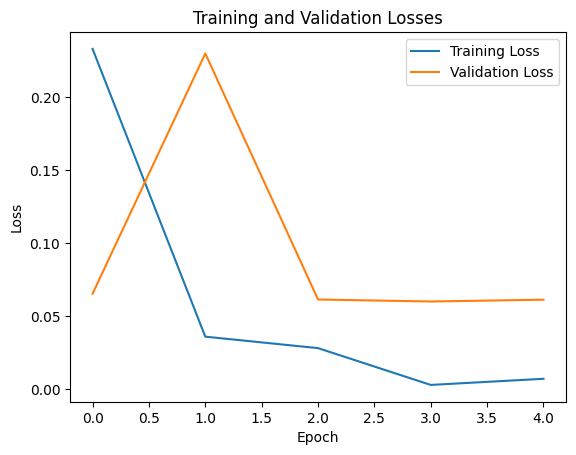

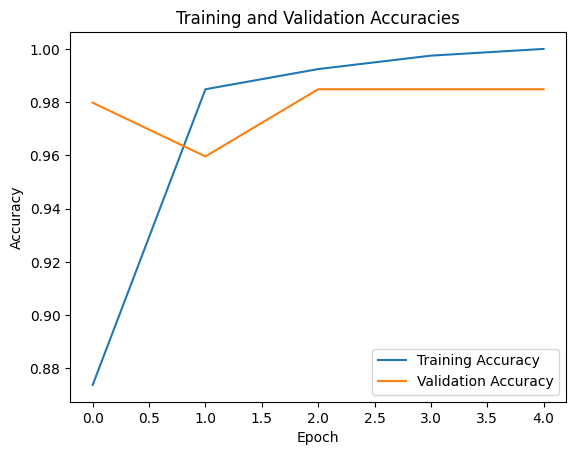

Training for class: fox
Fold 1
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2479, Train Acc: 0.8611, Val Loss: 0.0393, Val Acc: 0.9747
Epoch [2/5], Train Loss: 0.0510, Train Acc: 0.9899, Val Loss: 0.0294, Val Acc: 0.9848
Epoch [3/5], Train Loss: 0.0296, Train Acc: 0.9823, Val Loss: 0.4300, Val Acc: 0.9343
Epoch [4/5], Train Loss: 0.0284, Train Acc: 0.9899, Val Loss: 0.2033, Val Acc: 0.9646
Epoch [5/5], Train Loss: 0.0082, Train Acc: 0.9949, Val Loss: 0.0903, Val Acc: 0.9899


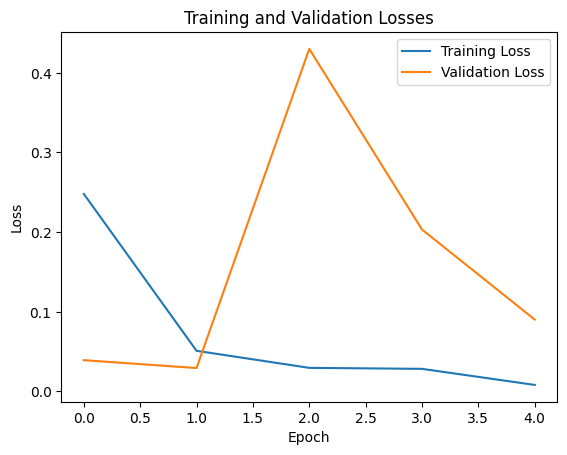

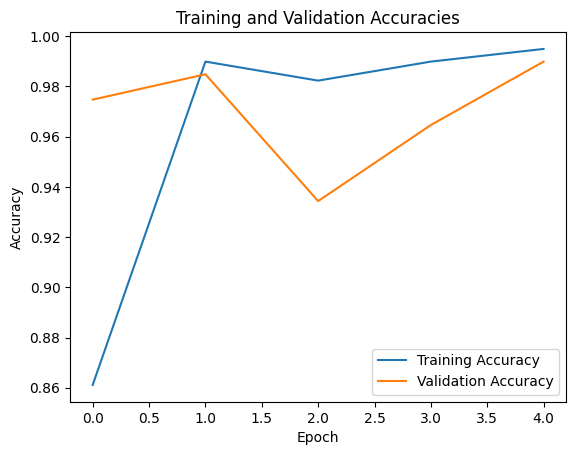

Fold 2
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2714, Train Acc: 0.8561, Val Loss: 1.4013, Val Acc: 0.7172
Epoch [2/5], Train Loss: 0.1235, Train Acc: 0.9646, Val Loss: 0.0754, Val Acc: 0.9697
Epoch [3/5], Train Loss: 0.0150, Train Acc: 0.9924, Val Loss: 0.0253, Val Acc: 0.9798
Epoch [4/5], Train Loss: 0.0078, Train Acc: 0.9949, Val Loss: 0.0389, Val Acc: 0.9848
Epoch [5/5], Train Loss: 0.0107, Train Acc: 0.9975, Val Loss: 0.0480, Val Acc: 0.9848


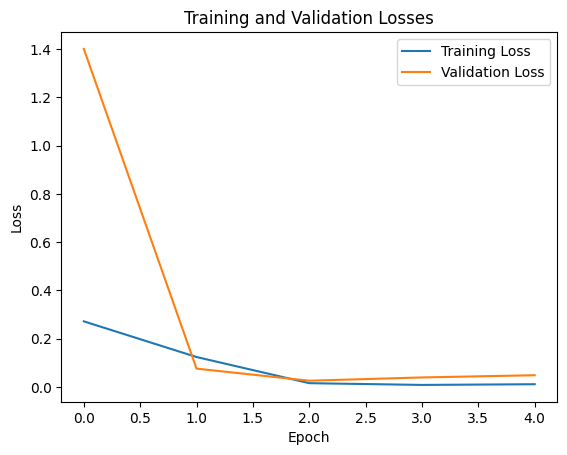

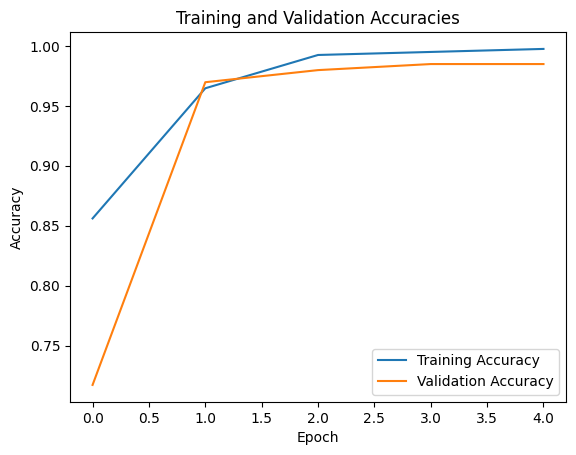

Fold 3
Loaded pretrained weights for efficientnet-b0
Epoch [1/5], Train Loss: 0.2425, Train Acc: 0.8788, Val Loss: 0.0591, Val Acc: 0.9747
Epoch [2/5], Train Loss: 0.0855, Train Acc: 0.9773, Val Loss: 0.6656, Val Acc: 0.9040
Epoch [3/5], Train Loss: 0.0149, Train Acc: 0.9924, Val Loss: 0.9309, Val Acc: 0.8939
Epoch [4/5], Train Loss: 0.0287, Train Acc: 0.9899, Val Loss: 0.8492, Val Acc: 0.9040
Epoch [5/5], Train Loss: 0.0101, Train Acc: 0.9949, Val Loss: 0.7323, Val Acc: 0.9141


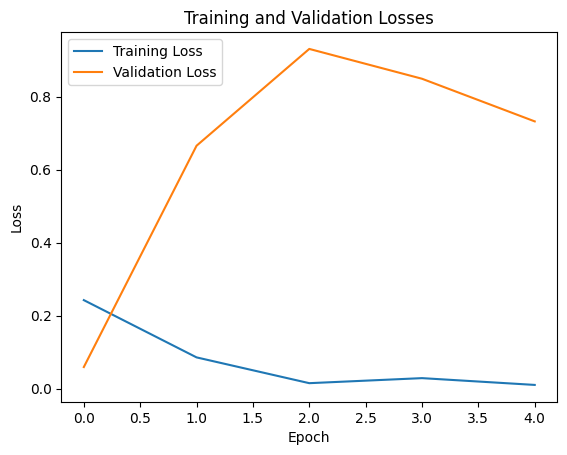

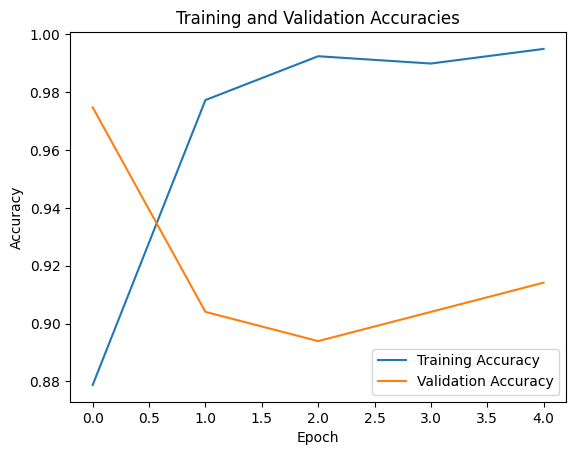

In [12]:
for target_class in animal_classes[:3]:
    print(f"Training for class: {target_class}")
    
    one_vs_rest_dataset = datasets[target_class]

    for fold_idx, (train_index, val_index) in enumerate(skf.split(one_vs_rest_dataset.data, one_vs_rest_dataset.targets)):
        print(f"Fold {fold_idx + 1}")

        train_dataset = Subset(one_vs_rest_dataset, train_index)
        val_dataset = Subset(one_vs_rest_dataset, val_index)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = EfficientNetBinary().to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, fold_idx)

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self._to_linear = None

        self.fc1 = nn.Linear(512 * 7 * 7, 4096) 
        self.fc2 = nn.Linear(4096, 1)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        
        x = x.view(-1, self._to_linear)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
num_epochs = 10
batch_size = 32

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

Training for class: beetle
Fold 1
Epoch [1/10], Train Loss: 0.9700, Train Acc: 0.8409, Val Loss: 0.3087, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3461, Train Acc: 0.8990, Val Loss: 0.2938, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3314, Train Acc: 0.8990, Val Loss: 0.2878, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.3018, Train Acc: 0.8990, Val Loss: 0.2869, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3231, Train Acc: 0.8990, Val Loss: 0.2856, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.3140, Train Acc: 0.8990, Val Loss: 0.2904, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.3142, Train Acc: 0.8990, Val Loss: 0.2890, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.3181, Train Acc: 0.8990, Val Loss: 0.2875, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2972, Train Acc: 0.8990, Val Loss: 0.2867, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.3088, Train Acc: 0.8990, Val Loss: 0.2866, Val Acc: 0.8990


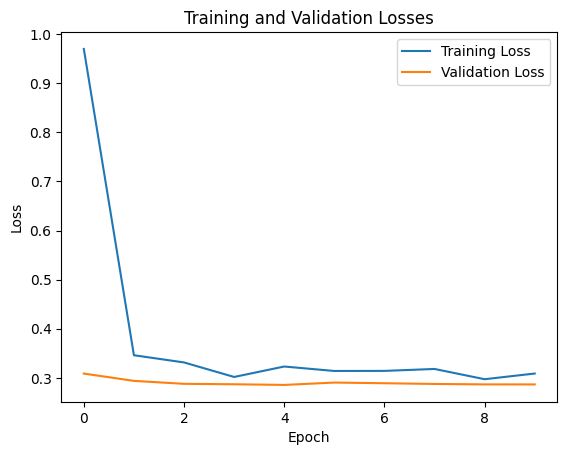

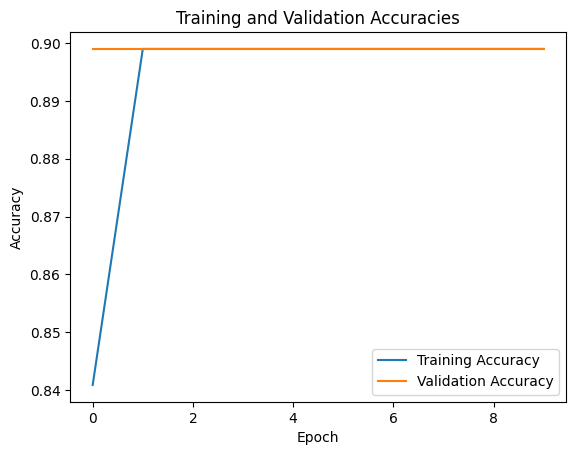

Fold 2
Epoch [1/10], Train Loss: 0.7026, Train Acc: 0.8434, Val Loss: 0.5255, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.4275, Train Acc: 0.8990, Val Loss: 0.2987, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3182, Train Acc: 0.8990, Val Loss: 0.2898, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.3176, Train Acc: 0.8990, Val Loss: 0.2892, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3092, Train Acc: 0.8990, Val Loss: 0.2906, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.3062, Train Acc: 0.8990, Val Loss: 0.2907, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.3120, Train Acc: 0.8990, Val Loss: 0.2905, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.3098, Train Acc: 0.8990, Val Loss: 0.2904, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2953, Train Acc: 0.8990, Val Loss: 0.2904, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.2955, Train Acc: 0.8990, Val Loss: 0.2904, Val Acc: 0.8990


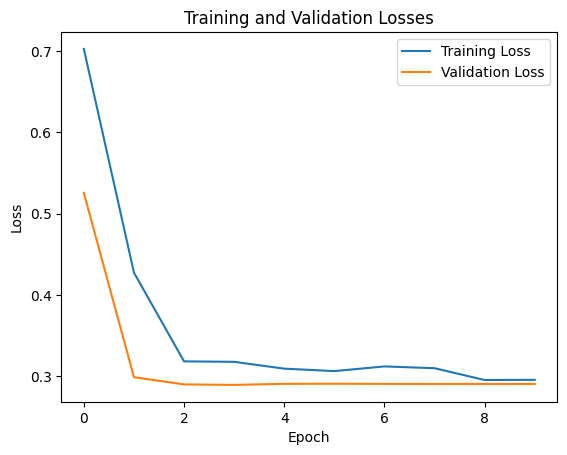

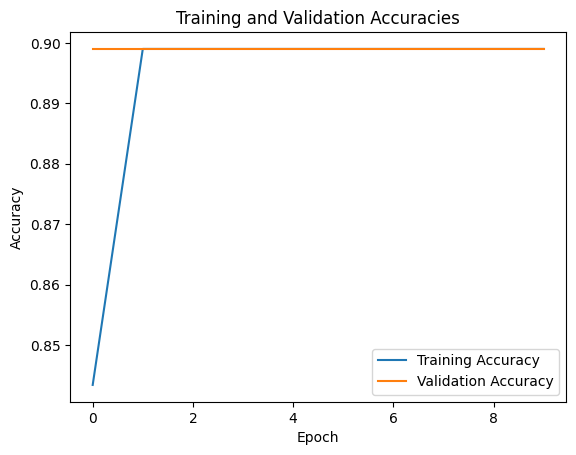

Fold 3
Epoch [1/10], Train Loss: 1.2250, Train Acc: 0.7702, Val Loss: 0.3164, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3472, Train Acc: 0.8990, Val Loss: 0.3376, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3507, Train Acc: 0.8990, Val Loss: 0.3050, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.3283, Train Acc: 0.8990, Val Loss: 0.3062, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3348, Train Acc: 0.8990, Val Loss: 0.3022, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.3157, Train Acc: 0.8990, Val Loss: 0.3006, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.3236, Train Acc: 0.8990, Val Loss: 0.3004, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.3150, Train Acc: 0.8990, Val Loss: 0.3003, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.3148, Train Acc: 0.8990, Val Loss: 0.2999, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.3320, Train Acc: 0.8990, Val Loss: 0.2999, Val Acc: 0.8990


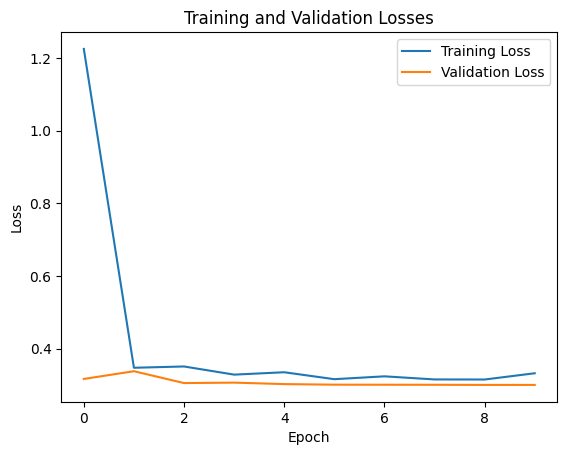

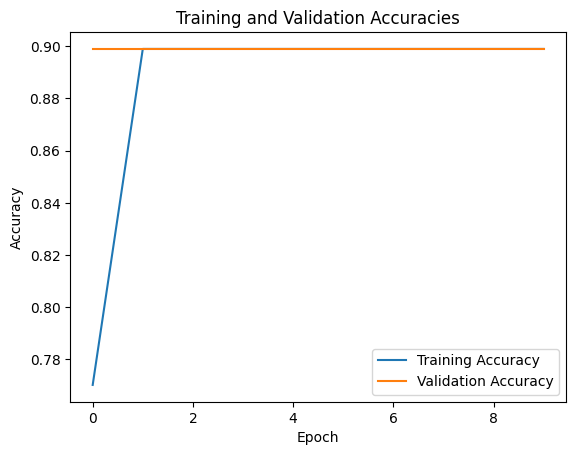

Training for class: parrot
Fold 1
Epoch [1/10], Train Loss: 1.1080, Train Acc: 0.8965, Val Loss: 0.3038, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3250, Train Acc: 0.8990, Val Loss: 0.2919, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.2698, Train Acc: 0.9066, Val Loss: 0.2766, Val Acc: 0.9242
Epoch [4/10], Train Loss: 0.2488, Train Acc: 0.9343, Val Loss: 0.1955, Val Acc: 0.9444
Epoch [5/10], Train Loss: 0.2015, Train Acc: 0.9444, Val Loss: 0.1789, Val Acc: 0.9394
Epoch [6/10], Train Loss: 0.2005, Train Acc: 0.9419, Val Loss: 0.1672, Val Acc: 0.9444
Epoch [7/10], Train Loss: 0.1832, Train Acc: 0.9444, Val Loss: 0.1668, Val Acc: 0.9444
Epoch [8/10], Train Loss: 0.1843, Train Acc: 0.9419, Val Loss: 0.1670, Val Acc: 0.9444
Epoch [9/10], Train Loss: 0.1935, Train Acc: 0.9444, Val Loss: 0.1673, Val Acc: 0.9444
Epoch [10/10], Train Loss: 0.1764, Train Acc: 0.9444, Val Loss: 0.1673, Val Acc: 0.9444


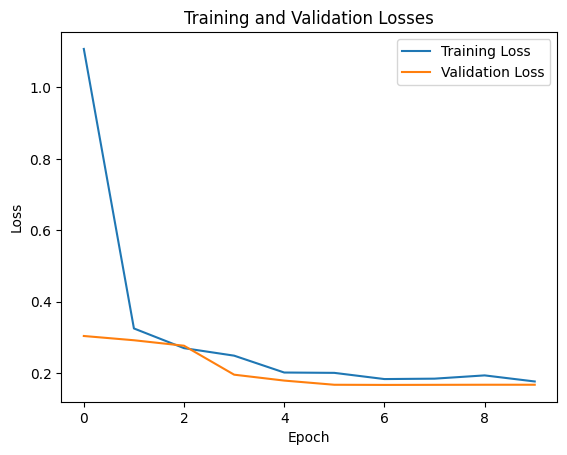

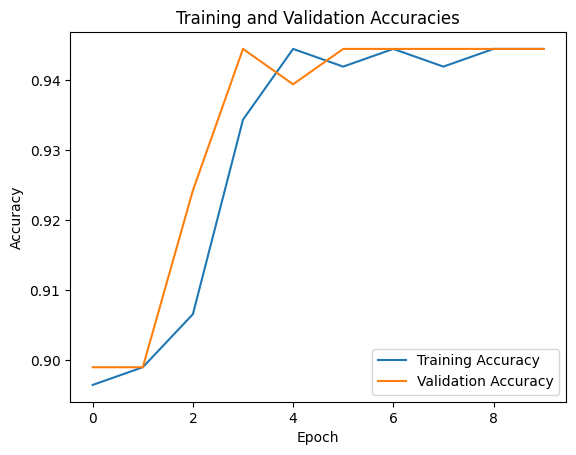

Fold 2
Epoch [1/10], Train Loss: 0.8975, Train Acc: 0.8535, Val Loss: 0.3071, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3348, Train Acc: 0.8990, Val Loss: 0.3062, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3056, Train Acc: 0.8990, Val Loss: 0.2839, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.2887, Train Acc: 0.8990, Val Loss: 0.2680, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.2594, Train Acc: 0.8990, Val Loss: 0.2582, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.2415, Train Acc: 0.8990, Val Loss: 0.2550, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.2305, Train Acc: 0.8990, Val Loss: 0.2536, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.2307, Train Acc: 0.8990, Val Loss: 0.2535, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2293, Train Acc: 0.8990, Val Loss: 0.2539, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.2256, Train Acc: 0.8990, Val Loss: 0.2539, Val Acc: 0.8990


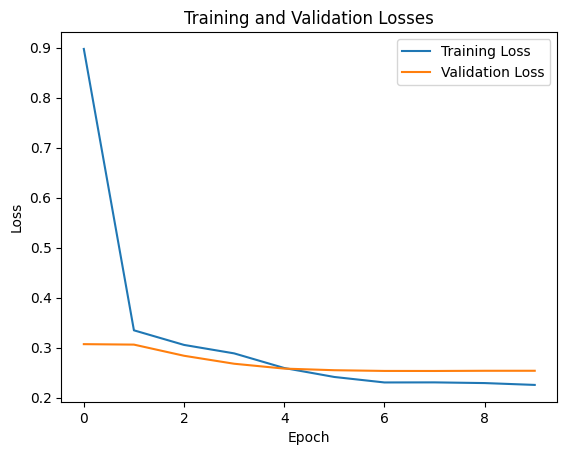

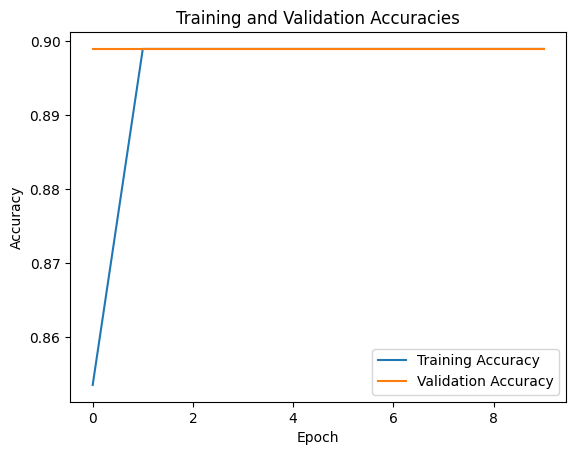

Fold 3
Epoch [1/10], Train Loss: 1.2147, Train Acc: 0.8333, Val Loss: 0.2994, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3371, Train Acc: 0.8990, Val Loss: 0.2882, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.2952, Train Acc: 0.8990, Val Loss: 0.1968, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.2423, Train Acc: 0.9167, Val Loss: 0.1882, Val Acc: 0.9343
Epoch [5/10], Train Loss: 0.2194, Train Acc: 0.9217, Val Loss: 0.1792, Val Acc: 0.9444
Epoch [6/10], Train Loss: 0.2173, Train Acc: 0.9369, Val Loss: 0.1738, Val Acc: 0.9495
Epoch [7/10], Train Loss: 0.2034, Train Acc: 0.9343, Val Loss: 0.1719, Val Acc: 0.9444
Epoch [8/10], Train Loss: 0.2030, Train Acc: 0.9369, Val Loss: 0.1716, Val Acc: 0.9495
Epoch [9/10], Train Loss: 0.2079, Train Acc: 0.9369, Val Loss: 0.1724, Val Acc: 0.9495
Epoch [10/10], Train Loss: 0.2091, Train Acc: 0.9369, Val Loss: 0.1724, Val Acc: 0.9495


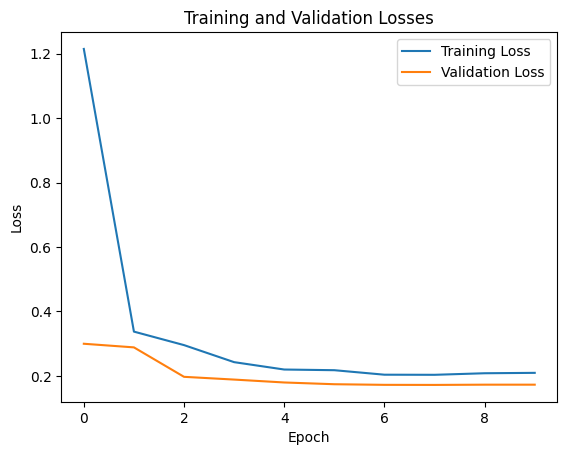

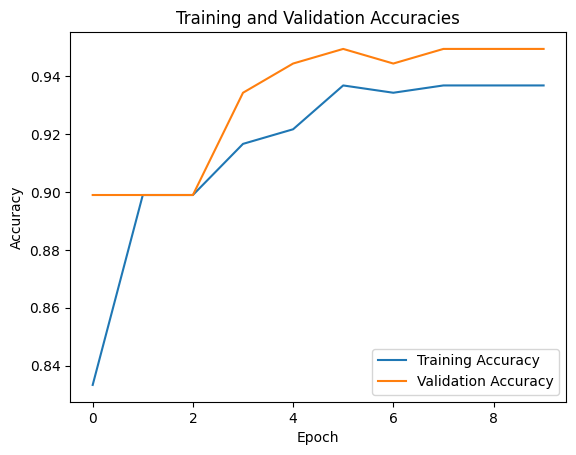

Training for class: fox
Fold 1
Epoch [1/10], Train Loss: 0.8158, Train Acc: 0.8333, Val Loss: 0.3027, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3395, Train Acc: 0.8990, Val Loss: 0.2846, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3137, Train Acc: 0.8990, Val Loss: 0.2820, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.2990, Train Acc: 0.8990, Val Loss: 0.2632, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3048, Train Acc: 0.8990, Val Loss: 0.2675, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.2998, Train Acc: 0.8990, Val Loss: 0.2567, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.2885, Train Acc: 0.8990, Val Loss: 0.2560, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.2778, Train Acc: 0.8990, Val Loss: 0.2546, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2764, Train Acc: 0.8990, Val Loss: 0.2525, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.3060, Train Acc: 0.8990, Val Loss: 0.2523, Val Acc: 0.8990


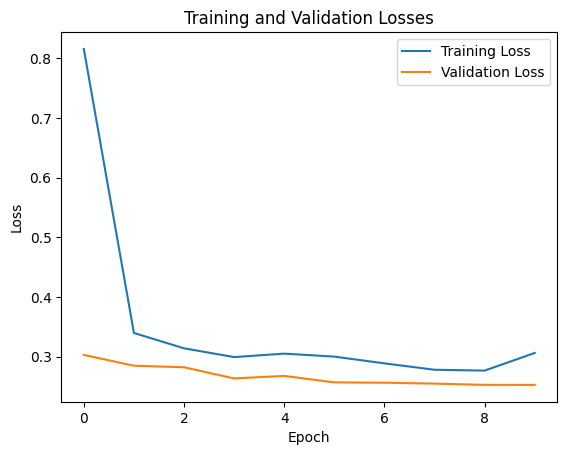

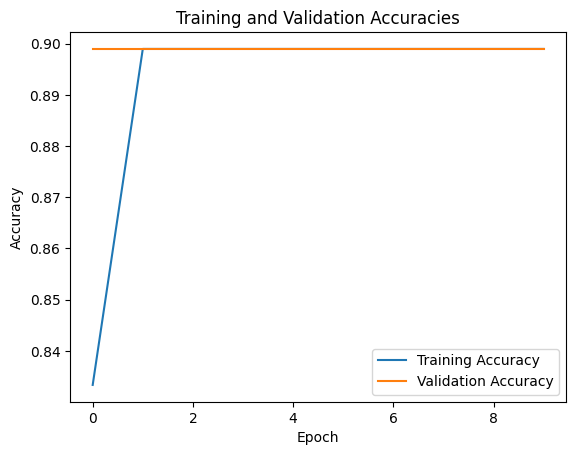

Fold 2
Epoch [1/10], Train Loss: 0.5639, Train Acc: 0.8384, Val Loss: 0.3499, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3726, Train Acc: 0.8990, Val Loss: 0.3186, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3228, Train Acc: 0.8990, Val Loss: 0.3216, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.3328, Train Acc: 0.8990, Val Loss: 0.2976, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3048, Train Acc: 0.8990, Val Loss: 0.3002, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.2981, Train Acc: 0.8990, Val Loss: 0.2975, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.3030, Train Acc: 0.8990, Val Loss: 0.2974, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.3108, Train Acc: 0.8990, Val Loss: 0.2970, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2834, Train Acc: 0.8990, Val Loss: 0.2967, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.2895, Train Acc: 0.8990, Val Loss: 0.2967, Val Acc: 0.8990


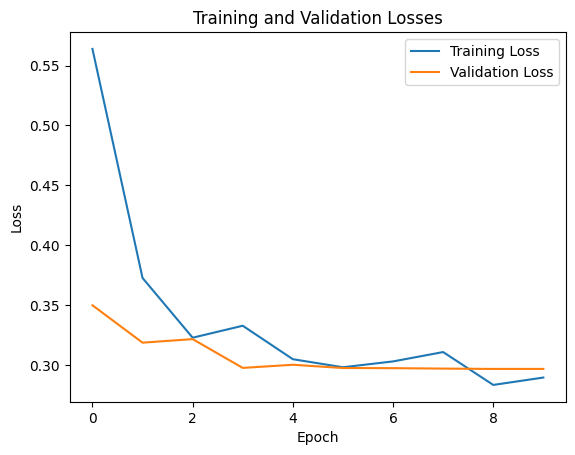

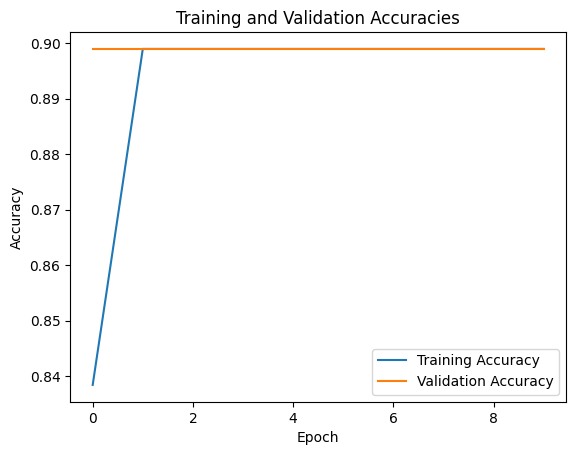

Fold 3
Epoch [1/10], Train Loss: 3.0798, Train Acc: 0.7727, Val Loss: 0.3324, Val Acc: 0.8990
Epoch [2/10], Train Loss: 0.3313, Train Acc: 0.8990, Val Loss: 0.3344, Val Acc: 0.8990
Epoch [3/10], Train Loss: 0.3287, Train Acc: 0.8990, Val Loss: 0.3038, Val Acc: 0.8990
Epoch [4/10], Train Loss: 0.3105, Train Acc: 0.8990, Val Loss: 0.2953, Val Acc: 0.8990
Epoch [5/10], Train Loss: 0.3088, Train Acc: 0.8990, Val Loss: 0.2957, Val Acc: 0.8990
Epoch [6/10], Train Loss: 0.3092, Train Acc: 0.8990, Val Loss: 0.2985, Val Acc: 0.8990
Epoch [7/10], Train Loss: 0.3255, Train Acc: 0.8990, Val Loss: 0.2976, Val Acc: 0.8990
Epoch [8/10], Train Loss: 0.3034, Train Acc: 0.8990, Val Loss: 0.2977, Val Acc: 0.8990
Epoch [9/10], Train Loss: 0.2951, Train Acc: 0.8990, Val Loss: 0.2973, Val Acc: 0.8990
Epoch [10/10], Train Loss: 0.3188, Train Acc: 0.8990, Val Loss: 0.2972, Val Acc: 0.8990


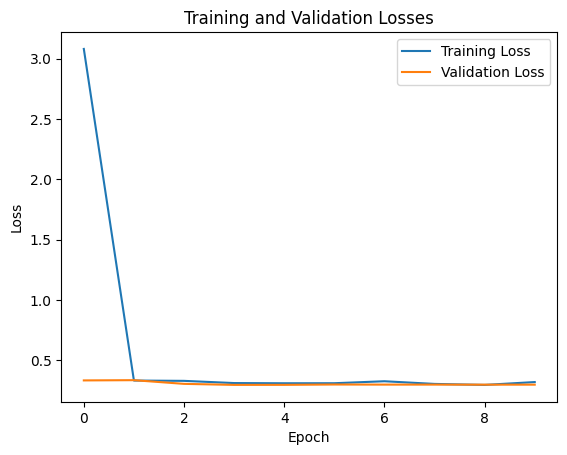

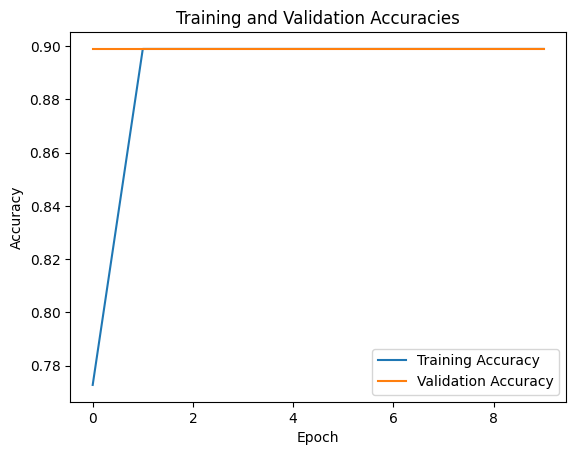

In [15]:
for target_class in animal_classes[:3]:
    print(f"Training for class: {target_class}")
    
    one_vs_rest_dataset = datasets[target_class]

    for fold_idx, (train_index, val_index) in enumerate(skf.split(one_vs_rest_dataset.data, one_vs_rest_dataset.targets)):
        print(f"Fold {fold_idx + 1}")

        train_dataset = Subset(one_vs_rest_dataset, train_index)
        val_dataset = Subset(one_vs_rest_dataset, val_index)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = CNN().to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, scheduler, fold_idx)

In [16]:
datasets.keys()

dict_keys(['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar'])

In the code, although dolphin is selected we get to see some insect because the one-vs-rest dataloader of dolphin also contains images of animals of different classes.

/tmp/ipykernel_26/3089455306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, j+1)


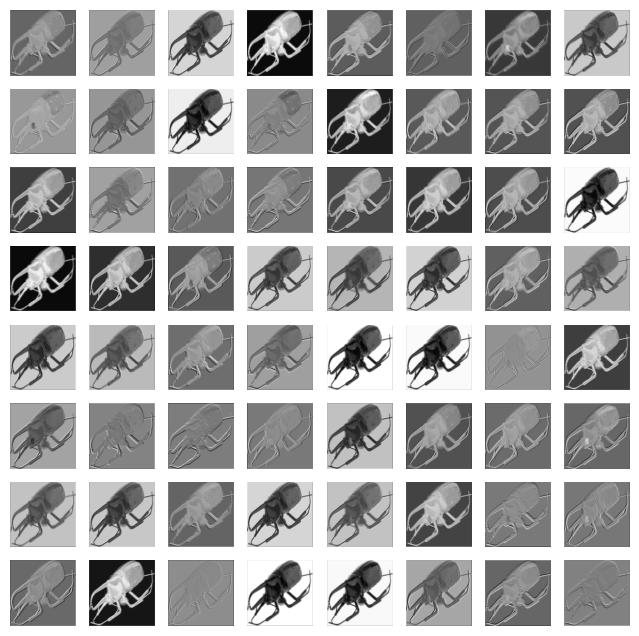

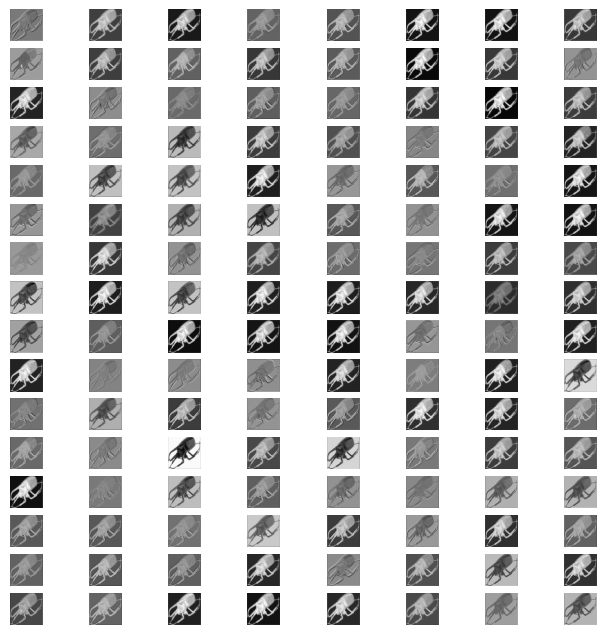

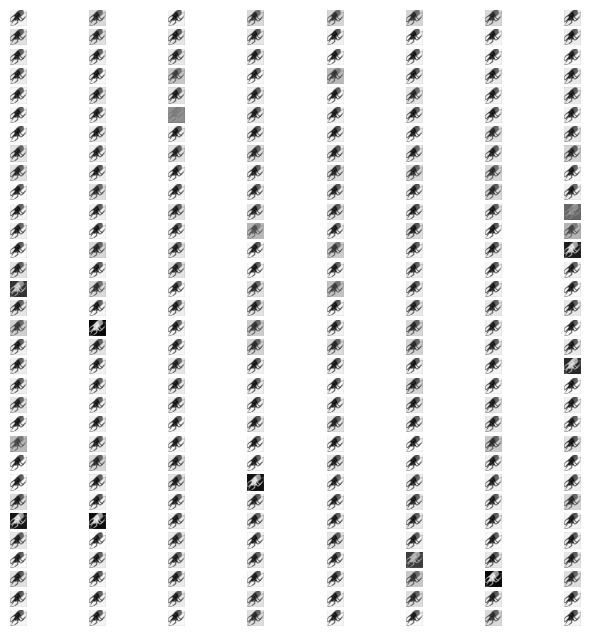

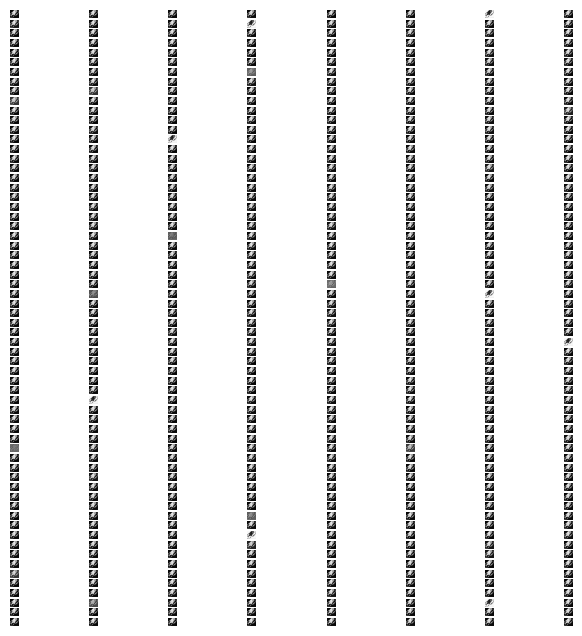

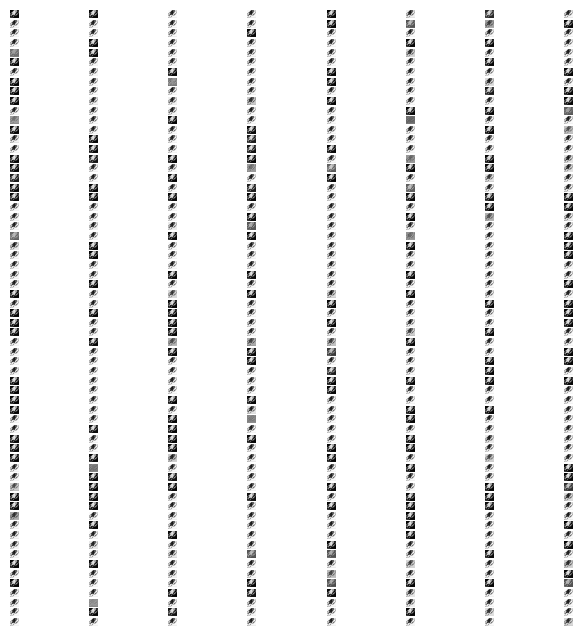

In [17]:
dataset = BinaryAnimalDataset(dataset_root, target_class='dolphin', transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

images, _ = next(iter(data_loader))

feature_maps = []
with torch.no_grad():
    x = images.cuda()
    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            x = layer(x)
            feature_maps.append(x)

# Plot the feature maps
for i, fmap in enumerate(feature_maps):
    num_feature_maps = fmap.shape[1]
    rows = int(np.ceil(num_feature_maps / 8))
    cols = min(num_feature_maps, 8)
    plt.figure(figsize=(8, 8))
    plt.title(f'Feature Map (Conv{i+1})')
    for j in range(num_feature_maps):
        plt.subplot(rows, cols, j+1)
        plt.imshow(fmap[0, j].cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()